# Raykar(RGZ): $\vec \alpha$ and $\vec \beta$

This notebook approximates the values of $\vec \alpha$ and $\vec \beta$ for crowd labellers on the Radio Galaxy Zoo galaxy classification task, and compares these to the values of $\vec \alpha$ and $\vec \beta$ estimated by the Raykar et al. algorithm.

## Approximate $\vec \alpha$ and $\vec \beta$

Here, I approximate $\vec \alpha$ and $\vec \beta$ by comparing annotator accuracy to the Norris et al. label set. $\vec \alpha$ is the sensitivity, and $\vec \beta$ is the specificity.

In [10]:
from pprint import pprint
import crowdastro.crowd.util
from crowdastro.crowd.raykar import RaykarClassifier
import crowdastro.experiment.experiment_rgz_raykar as rgzr
from crowdastro.experiment.results import Results
import crowdastro.plot
import h5py
import matplotlib.pyplot as plt
import numpy
import sklearn.metrics

%matplotlib inline

CROWDASTRO_PATH = '../data/crowdastro.h5'  # Generated by the crowdastro pipeline.
RESULTS_PATH = '../data/results_rgz_raykar.h5'  # Generated by crowdastro.experiment.experiment_rgz_raykar.

In [2]:
with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    norris_labels = crowdastro_h5['/wise/cdfs/norris_labels'].value
    crowd_labels = numpy.ma.MaskedArray(
        crowdastro_h5['/wise/cdfs/rgz_raw_labels'],
        mask=crowdastro_h5['/wise/cdfs/rgz_raw_labels_mask'])
    
    top_10 = rgzr.top_n_accurate_targets(crowdastro_h5, n_annotators=10)

approximate alpha:
[0.8045977011494253,
 0.78974358974358971,
 0.90000000000000002,
 0.88888888888888884,
 0.79411764705882348,
 0.84999999999999998,
 0.875,
 0.90566037735849059,
 0.86274509803921573,
 0.80000000000000004]
approximate beta:
[0.90905935439083652,
 0.92548683521401709,
 0.81853582554517135,
 0.83779527559055122,
 0.94905660377358492,
 0.89588688946015427,
 0.87287024901703802,
 0.85450208706022657,
 0.90947666195190946,
 0.97897503285151122]


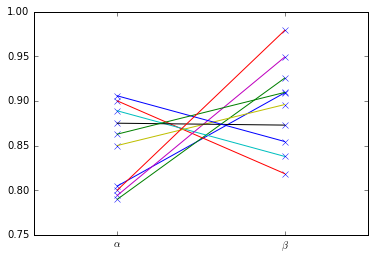

In [4]:
approx_alphas = []
approx_betas = []
for t in range(top_10.shape[0]):
    cm = sklearn.metrics.confusion_matrix(norris_labels[~top_10[t].mask],
                                          top_10[t][~top_10[t].mask])
    alpha = cm[1, 1] / cm.sum(axis=1)[1]
    beta = cm[0, 0] / cm.sum(axis=1)[0]
    approx_alphas.append(alpha)
    approx_betas.append(beta)

print('approximate alpha:')
pprint(approx_alphas)
print('approximate beta:')
pprint(approx_betas)

crowdastro.plot.vertical_scatter(['$\\alpha$', '$\\beta$'], [approx_alphas, approx_betas], line=True)
plt.show()

It seems that higher values of $\alpha$ are correlated with lower values of $\beta$, and vice versa. This seems to make some intuitive sense.

## Raykar-estimated $\vec \alpha$ and $\vec \beta$

Here, I retrieve the $\vec \alpha$ and $\vec \beta$ estimated by the Raykar et al. algorithm and compare to the approximated values found previously. I will average the values approximated across all splits trialled.

In [6]:
results = Results.from_path(RESULTS_PATH)

raykar alpha:
[0.00012394363556225303,
 0.0087219112419541465,
 0.0021893432229240341,
 0.001487924879267744,
 0.0010799246141165795,
 0.00012175597320699439,
 0.0001059262444415627,
 0.00086513787305485864,
 5.9853061201775843e-05,
 0.00011090426060211657]
raykar beta:
[0.0026029925485256977,
 0.64721624646722864,
 0.00018712633080707292,
 0.00020643516310343244,
 0.0045254715563698708,
 2.9936639405227483e-08,
 0.00031904929460759414,
 0.00038936306704026,
 0.0016256753388109659,
 0.0021869879975549575]


c:\users\matthew\repos\crowdastro\crowdastro\crowd\raykar.py:295: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rc.a_ = array[:n_annotators]
c:\users\matthew\repos\crowdastro\crowdastro\crowd\raykar.py:296: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rc.b_ = array[n_annotators:n_annotators * 2]
c:\users\matthew\repos\crowdastro\crowdastro\crowd\raykar.py:297: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rc.w_ = array[n_annotators * 2:]


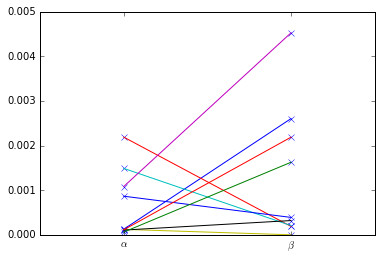

In [22]:
raykar_alphas = []
raykar_betas = []
raykar_classifiers = []
for split in range(results.n_splits):
    rc = results.get_model('Raykar(Top-10-accurate)', split)
    rc = RaykarClassifier.unserialise(rc)
    raykar_alphas.append(rc.a_)
    raykar_betas.append(rc.b_)
    raykar_classifiers.append(rc)
raykar_alphas = numpy.mean(raykar_alphas, axis=0)
raykar_betas = numpy.mean(raykar_betas, axis=0)

print('raykar alpha:')
pprint(list(raykar_alphas))
print('raykar beta:')
pprint(list(raykar_betas))

crowdastro.plot.vertical_scatter(['$\\alpha$', '$\\beta$'], [raykar_alphas, raykar_betas], line=True)
plt.ylim(0, 0.005)
plt.show()

These numbers are all *really* small. This may be because the Raykar algorithm doesn't account for the fact that the labels are partially observed. If this is the case, then the Raykar algorithm is estimating the values as

$$
\alpha = \frac{\text{true positives}}{\text{true positives} + \text{false negatives} + \text{unobserved}}
$$


$$
\beta = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives} + \text{unobserved}}
$$

where we want

$$
\alpha = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}
$$


$$
\beta = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}.
$$